In [60]:
import magic
import scprep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
emt_data = scprep.io.load_csv('../../data/magic/HMLE_TGFb_day_8_10.csv.gz', cell_names=False, sparse = True)
emt_data.head()

,5S_rRNA,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [334]:
X = emt_data.iloc[0:250, :]

In [335]:
X = scprep.normalize.library_size_normalize(X)

In [336]:
X_norm = np.array(X.T/X.sum(1))

In [337]:
import pykeops
import torch
from pykeops.torch import LazyTensor
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor


tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.FloatTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float32


In [338]:
import sys
sys.path.insert(0, "/home/zsteve/wtf/src")
import wtf

In [339]:
genenames = X.columns.values

In [357]:
x = tl.tensor(X_norm, dtype = tl_dtype).to(device)
expressed_tot = x.sum(1)
thresh = np.quantile(expressed_tot.cpu(), 0.75)
expressed_idx = (x.sum(1) > thresh).cpu()
expressed_idx = expressed_idx | ((genenames == 'VIM') | (genenames == 'CDH1') | (genenames == 'ZEB1'))

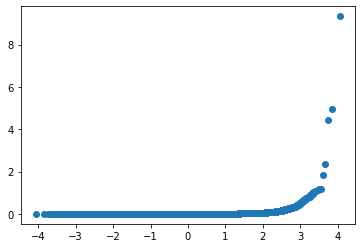

In [358]:
import scipy
from scipy import stats
plt.scatter(*scipy.stats.probplot(expressed_tot.cpu())[0])

In [360]:
expressed_idx = expressed_idx.bool()

In [361]:
x = x[expressed_idx, ]
x = x/x.sum(0)
gene_means = x.mean(1).reshape(-1, 1)
gene_dev = torch.sqrt(((x - gene_means)**2).sum(1)).reshape(-1, 1)
x_std = (x - gene_means)/gene_dev
# x_i = LazyTensor(x_std.view(1, x.shape[0], x.shape[1]))
# x_j = LazyTensor(x_std.view(x.shape[0], 1, x.shape[1]))
# C = (1 - (x_i * x_j).sum(2)).sqrt()

In [362]:
C = (1 - (x_std @ x_std.T) + 1e-4).sqrt()

In [363]:
C.shape

torch.Size([7229, 7229])

In [364]:
import sklearn
from sklearn import decomposition
import copy
r_nmf = [25, ]*2
S_nmf = tl.zeros(r_nmf).to(device)
for i in range(r_nmf[0]):
    S_nmf[i, i] = 1

X0_nmf = x.to(device).T
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd", max_iter = 1)
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)

U_nmf = (U_nmf.T/U_nmf.sum(1)).T
V_nmf = (V_nmf.T/V_nmf.sum(1)).T

A_nmf = copy.deepcopy([U_nmf, V_nmf.T])
A_nmf = [a.to(device) for a in A_nmf]

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [365]:
params_nmf = {"n_iter" : 10}
params_nmf['lr'] = np.ones(params_nmf['n_iter'])*1
params_nmf['lamda'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*25
params_nmf['optim_modes'] = [0, ]
params_nmf['rho'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.025
params_nmf['eps'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.025

In [366]:
import importlib
importlib.reload(wtf)

<module 'wtf' from '/home/zsteve/wtf/src/wtf.py'>

In [367]:
max_iter, print_inter, check_iter, unbal = (100, 10, 10, False)
tol = 1e-3
mode = "lbfgs"
for i in range(params_nmf['n_iter']):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0_nmf, 0, [C, ], S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "row")
    wtf.solve(m0, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0_nmf, 1, [C, ], S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    wtf.solve(m1, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[1] = m1.compute_primal_variable().detach()

Block iteration  0
Mode 0
i = 0 	 dual = 51.276230
i = 10 	 dual = -19.907288
i = 20 	 dual = -22.187981
i = 30 	 dual = -22.328815
i = 40 	 dual = -22.353619
i = 50 	 dual = -22.359882
i = 60 	 dual = -22.360966
Mode 1
i = 0 	 dual = 52.160023
i = 10 	 dual = 26.179012
i = 20 	 dual = 9.751878
i = 30 	 dual = -1.131113
i = 40 	 dual = -8.412784
i = 50 	 dual = -14.125713
i = 60 	 dual = -17.975182
i = 70 	 dual = -20.544544
i = 80 	 dual = -22.072174
i = 90 	 dual = -22.955158
Block iteration  1
Mode 0
i = 0 	 dual = 50.695190
i = 10 	 dual = -12.036165
i = 20 	 dual = -13.995764
i = 30 	 dual = -14.280090
i = 40 	 dual = -14.340275
i = 50 	 dual = -14.356129
i = 60 	 dual = -14.361164
i = 70 	 dual = -14.362999
Mode 1
i = 0 	 dual = 51.770462
i = 10 	 dual = 6.663279
i = 20 	 dual = -12.574800
i = 30 	 dual = -20.093304
i = 40 	 dual = -22.398712
i = 50 	 dual = -22.999847
i = 60 	 dual = -23.192045
i = 70 	 dual = -23.277843
i = 80 	 dual = -23.321327
i = 90 	 dual = -23.346043
Bloc

KeyboardInterrupt: 

In [368]:
X_hat_nmf = tl.tenalg.multi_mode_dot(S_nmf, A_nmf ).cpu()
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd")
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)
X_nmf = U_nmf @ V_nmf

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(-0.5, 24.5, 7228.5, -0.5)

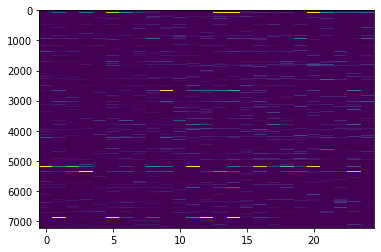

In [369]:
plt.imshow(A_nmf[1].cpu(), interpolation = "nearest", vmax = 0.01)
plt.axis("auto")

(-0.5, 24.5, 7228.5, -0.5)

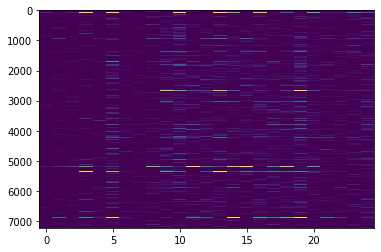

In [370]:
plt.imshow(V_nmf.T, interpolation = "nearest", vmax = 0.05)
plt.axis("auto")

(-0.5, 7228.5, 249.5, -0.5)

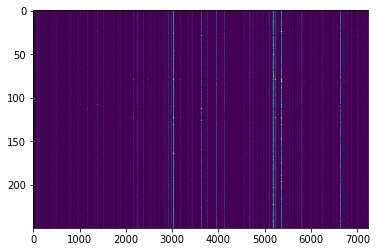

In [371]:
plt.imshow(X_hat_nmf, interpolation = 'nearest', vmax = 0.01)
plt.axis("auto")

(-0.5, 7228.5, 249.5, -0.5)

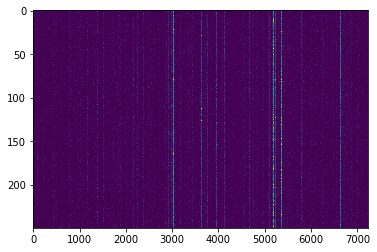

In [372]:
plt.imshow(x.cpu().T, interpolation = 'nearest', vmax = 0.01)
plt.axis('auto')

In [373]:
vim_wtf = X_hat_nmf[:, genenames[expressed_idx] == 'VIM']
cdh1_wtf = X_hat_nmf[:, genenames[expressed_idx] == 'CDH1']

vim_nmf = X_nmf[:, genenames[expressed_idx] == 'VIM']
cdh1_nmf = X_nmf[:, genenames[expressed_idx] == 'CDH1']

Text(0, 0.5, 'cdh1')

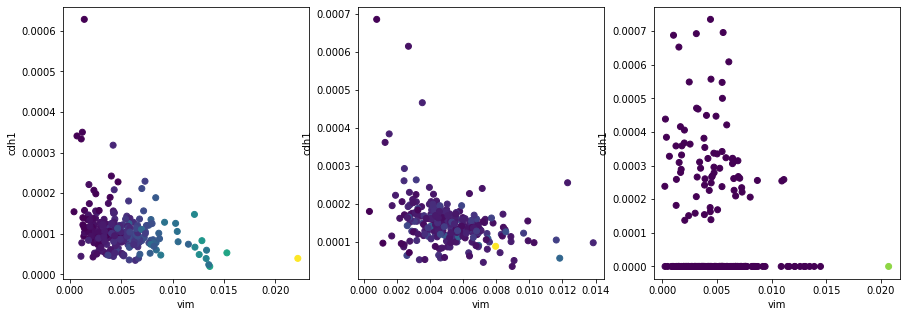

In [374]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_nmf[:, genenames[expressed_idx] == 'VIM'], X_nmf[:, genenames[expressed_idx] == 'CDH1'], 
           c = X_nmf[:, genenames[expressed_idx] == 'ZEB1'])
plt.xlabel('vim')
plt.ylabel('cdh1')

plt.subplot(1, 3, 2)
plt.scatter(X_hat_nmf[:, genenames[expressed_idx] == 'VIM'], X_hat_nmf[:, genenames[expressed_idx] == 'CDH1'], 
           c = X_hat_nmf[:, genenames[expressed_idx] == 'ZEB1'])
plt.xlabel('vim')
plt.ylabel('cdh1')

plt.subplot(1, 3, 3)
plt.scatter(X0_nmf[:, genenames[expressed_idx] == 'VIM'].cpu(), X0_nmf[:, genenames[expressed_idx] == 'CDH1'].cpu(), 
           c = X0_nmf[:, genenames[expressed_idx] == 'ZEB1'].cpu())
plt.xlabel('vim')
plt.ylabel('cdh1')